# Benjamin Panovich 
# bpanovich@uchicago.edu
# ID: 12365148

In [775]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from tabulate import tabulate

In [857]:
UK_OIS = (quandl.get('YC/GBR_ISSC',returns="pandas",
                     api_key='xpFGWP_Rsch8wawp_DLL'))/100
UK_OIS1 = (quandl.get('YC/GBR_ISSS', returns="pandas",
                     api_key='xpFGWP_Rsch8wawp_DLL'))/100
VNM_YC = (quandl.get('YC/VNM', returns="pandas",
                     api_key='xpFGWP_Rsch8wawp_DLL'))/100
THAI_YC = (quandl.get('YC/THA', returns="pandas",
                     api_key='xpFGWP_Rsch8wawp_DLL'))/100
PAK_YC = (quandl.get('YC/PAK', returns="pandas",
                     api_key='xpFGWP_Rsch8wawp_DLL'))/100
PHIL_YC = (quandl.get('YC/PHL', returns="pandas",
                     api_key='xpFGWP_Rsch8wawp_DLL'))/100
USA_YC = (quandl.get('YC/USA', returns="pandas",
                     api_key='xpFGWP_Rsch8wawp_DLL'))/100
LIBOR = (quandl.get('FRED/DFF', returns="pandas",
                     api_key='xpFGWP_Rsch8wawp_DLL'))/100
USA_YC = USA_YC.drop(['7-Year', '10-Year', '20-Year', '30-Year'], axis=1)
USA_YC.dropna(inplace=True)
NZL_YC = (quandl.get('YC/NZL', returns="pandas",
                     api_key='xpFGWP_Rsch8wawp_DLL'))/100


In [858]:
GBP = quandl.get('CUR/GBP', returns="pandas",
                     api_key='xpFGWP_Rsch8wawp_DLL')
VND = quandl.get('CUR/VND', returns="pandas",
                     api_key='xpFGWP_Rsch8wawp_DLL')
THB = quandl.get('CUR/THB', returns="pandas",
                     api_key='xpFGWP_Rsch8wawp_DLL')
PKR = quandl.get('CUR/PKR', returns="pandas",
                     api_key='xpFGWP_Rsch8wawp_DLL')
PHP = quandl.get('CUR/PHP', returns="pandas",
                     api_key='xpFGWP_Rsch8wawp_DLL')
NZD = quandl.get('CUR/NZD', returns="pandas",
                     api_key='xpFGWP_Rsch8wawp_DLL')

In [860]:
UK_yield1 = UK_OIS[['0.08Y', '5.0Y']]
UK_yield2 = UK_OIS1[['0.08Y', '5.0Y']]
UK_YC = pd.concat([UK_yield1, UK_yield2])
VNM_YC.columns = [1,2,3,5,7,10,15]
THAI_YC.columns = [.08,3/12,6/12,1,2,3,4,5,6,7,8,9,10,15]
PAK_YC.columns = [3/12,6/12,1,3,5,10]
PHIL_YC.columns = [.08,3/12,6/12,1,2,3,4,5,7,10,20,25]
USA_YC.columns = [.08,3/12,6/12,1,2,3,5]
NZL_YC.columns = [.08,2/12,3/12,1,2,5,10]
UK_YC.columns = [.08, 5]

In [862]:
NZL_YC.dropna(inplace=True)

In [863]:
VNM_YC = VNM_YC.resample('W-WED').ffill()
THAI_YC = THAI_YC.resample('W-WED').ffill()
PAK_YC = PAK_YC.resample('W-WED').ffill()
PHIL_YC = PHIL_YC.resample('W-WED').ffill()
UK_YC = UK_YC.drop_duplicates()
UK_YC = UK_YC.resample('W-WED').ffill()
NZL_YC = NZL_YC.resample('W-WED').ffill()

In [555]:
def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor, spot_rate in spot.iteritems():
            if tenor>0.001:
                times = np.arange(tenor-0.25, 0, step=-0.25)[::-1]
                coupon_quarter_yr = 0.25*spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values) # Linear interpolation
                preceding_coupons_val = (coupon_quarter_yr*np.exp(-z*times)).sum()
                zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_quarter_yr))/tenor
    return zcb_rates
def bond_price(zcb, coupon_rate, tenor):
    times = np.arange(tenor,0, step=-0.25)[::-1]
    if times.shape[0]==0:
        p = 1.0
    else:
        r = np.interp(times, zcb.index.values, zcb.values[:,0]) # Linear interpolation
        p = np.exp(-tenor*r[-1]) + 0.25 * coupon_rate * np.exp(-r*times).sum()
    return p
def spot_rate(zcb, tenor):
    times = np.arange(tenor, 0, step=-0.25)[::-1]
    if times.shape[0]==0:
        sr = None
    else:
        r = np.interp(times, zcb.index.values, zcb.values) # Linear interpolation
        coupons_pv_x = 0.5*np.exp(-r*times).sum()
        final_pv = np.exp(-tenor*r[-1])
        sr = (1.0 - final_pv) / coupons_pv_x # Solves x + c * delta = 1.0
    return sr
def compute_spot_rates(zcb_rates):
    spot = zcb_rates.copy()
    for curve in zcb_rates.columns:
        zcb = zcb_rates[curve]
        for tenor, rate in zcb.iteritems():
            if tenor>0.001:
                spot[curve][tenor] = spot_rate(zcb, tenor)
    return spot

In [573]:
USA_YC1 = USA_YC.T
VNM_YC1 = VNM_YC.T
THAI_YC1 = THAI_YC.T
PAK_YC1 = PAK_YC.T
PHIL_YC1 = PHIL_YC.T

In [865]:
NZL_YC1 = NZL_YC.T

In [866]:
USA_YC1.index.name = "Tenor"
VNM_YC.index.name = "Tenor"
THAI_YC1.index.name = "Tenor"
PAK_YC1.index.name = "Tenor"
PHIL_YC1.index.name = "Tenor"
NZL_YC1.index.name = "Tenor"

In [574]:
VNM_zero = compute_zcb_curve(VNM_YC1.loc[[1, 3, 5], :])
THAI_zero = compute_zcb_curve(THAI_YC1.loc[[1, 3, 5], :])
PAK_zero = compute_zcb_curve(PAK_YC1.loc[[1, 3, 5], :])
PHIL_zero = compute_zcb_curve(PHIL_YC1.loc[[1, 3, 5], :])
USA_zero = compute_zcb_curve(USA_YC1.loc[[1, 3, 5], :])

In [868]:
NZL_zero = compute_zcb_curve(NZL_YC1.loc[[1, 2, 5], :])

In [575]:
VNM_zero1 = VNM_zero.T
THAI_zero1 = THAI_zero.T
PAK_zero1 = PAK_zero.T
PHIL_zero1 = PHIL_zero.T
USA_zero1 = USA_zero.T

In [869]:
NZL_zero1 = NZL_zero.T

In [580]:
USA_YC2 = USA_YC1.T
VNM_YC2 = VNM_YC1.T
THAI_YC2 = THAI_YC1.T
PAK_YC2 = PAK_YC1.T
PHIL_YC2 = PHIL_YC1.T

In [870]:
NZL_YC2 = NZL_YC1.T

In [874]:
NZL_data = pd.merge(NZL_zero1,GBP , left_index=True, right_index=True)
NZL_data = pd.merge(NZL_data, UK_YC, left_index=True, right_index=True)
NZL_data = pd.merge(NZL_data, NZD, left_index=True, right_index=True)
NZL_data.columns = ['1Y','2Y','5Y','GBP','OIS','GBP5Y','Exchange Rate']
NZL_data['coupon'] = NZL_YC2[[5]]
NZL_data['spread_check'] = np.where((NZL_data['coupon'] - NZL_data['GBP5Y']) > .005, True, False)
NZL_zero3 = NZL_zero1.loc[NZL_data.index]

In [746]:
VNM_data = pd.merge(VNM_zero1,GBP , left_index=True, right_index=True)
VNM_data = pd.merge(VNM_data, UK_YC, left_index=True, right_index=True)
VNM_data = pd.merge(VNM_data, VND, left_index=True, right_index=True)
VNM_data.columns = ['1Y','3Y','5Y','GBP','OIS','GBP5Y','Exchange Rate']
VNM_data['coupon'] = VNM_YC2[[5]]
VNM_data['spread_check'] = np.where((VNM_data['coupon'] - VNM_data['GBP5Y']) > .005, True, False)
VNM_zero3 = VNM_zero1.loc[VNM_data.index]

In [716]:
THAI_data = pd.merge(THAI_zero1,GBP , left_index=True, right_index=True)
THAI_data = pd.merge(THAI_data,UK_YC , left_index=True, right_index=True)
THAI_data = pd.merge(THAI_data,THB , left_index=True, right_index=True)
THAI_data.columns = ['1Y','3Y','5Y','GBP','OIS','GBP5Y','Exchange Rate']
THAI_data['coupon'] = THAI_YC2[[5]]
THAI_data['spread_check'] = np.where((THAI_data['coupon'] - THAI_data['GBP5Y']) > .005, True, False)
THAI_zero3 = THAI_zero1.loc[THAI_data.index]

In [720]:
PAK_data = pd.merge(PAK_zero1,GBP , left_index=True, right_index=True)
PAK_data = pd.merge(PAK_data,UK_YC , left_index=True, right_index=True)
PAK_data = pd.merge(PAK_data,PKR , left_index=True, right_index=True)
PAK_data.columns = ['1Y','3Y','5Y','GBP','OIS','GBP5Y','Exchange Rate']
PAK_data['coupon'] = PAK_YC2[[5]]
PAK_data['spread_check'] = np.where((PAK_data['coupon'] - PAK_data['GBP5Y']) > .005, True, False)
PAK_zero3 = PAK_zero1.loc[PAK_data.index]

In [836]:
PHIL_data = pd.merge(PHIL_zero1,GBP , left_index=True, right_index=True)
PHIL_data = pd.merge(PHIL_data,UK_YC , left_index=True, right_index=True)
PHIL_data = pd.merge(PHIL_data,PHP , left_index=True, right_index=True)
PHIL_data.columns = ['1Y','3Y','5Y','GBP','OIS','GBP5Y','Exchange Rate']
PHIL_data['coupon'] = PHIL_YC2[[5]]
PHIL_data['spread_check'] = np.where((PHIL_data['coupon'] - PHIL_data['GBP5Y']) > .005, True, False)
PHIL_zero3 = PHIL_zero1.loc[PHIL_data.index]

In [848]:
def carry_trade(data, zero):
    carry = pd.DataFrame(index = data.index, columns = ['pounds','GBP_pnl','bond_price','interest','cash','Pounds','Fx', 'position','new_bond','new_value','FX_pnl','total_pnl'])
    carry['cash'] = 10000000
    carry['interest'] = carry.apply(lambda row: 8000000 * ((data.loc[row.name, 'OIS'] + 0.005))/52, axis=1)
    carry['pounds'] = carry['cash'] * data['GBP']
    carry['GBP_pnl'] = 8000000 - ((8000000 * (data['GBP'].shift(-1) / data['GBP'])) - carry['interest'])
    carry['Fx'] = data['Exchange Rate'] * carry['cash']
    for index, (carry_row, data_row) in enumerate(zip(carry.iterrows(), data.iterrows())):
        zero.reset_index(drop=True)
        data.reset_index(drop=True)
        carry['bond_price'][index] = bond_price(zero.iloc[index].to_frame(),data.iloc[index]['coupon'], 5)
        try:
            next_index = index + 1
            carry['new_bond'][index] = bond_price(zero.iloc[next_index].to_frame(),data.iloc[index]['coupon'], (259/52))
        except IndexError:
            pass
    carry['position'] = carry['Fx'] / carry['bond_price']
    carry['new_value'] = carry['new_bond'] * carry['position']
    for index, (carry_row, data_row) in enumerate(zip(carry.iterrows(), data.iterrows())):
        zero.reset_index(drop=True)
        data.reset_index(drop=True)
        try:
            next_index = index + 1
            carry['FX_pnl'][index] = (carry['new_value'][index]/data['Exchange Rate'][next_index])-10_000_000
        except IndexError:
            pass
    carry['total_pnl'] = carry['GBP_pnl'] + carry['FX_pnl']
    carry['spread_check'] = data['spread_check']
    carry['traded_pnl'] = np.where(carry['spread_check'] == True, carry['total_pnl'], 0)
    carry['traded_fx_pnl'] = np.where(carry['spread_check'] == True, carry['FX_pnl'], 0)
    carry['traded_GBP_pnl'] = np.where(carry['spread_check'] == True, carry['GBP_pnl'], 0)
    return carry

In [790]:
VNM_carry = carry_trade(VNM_data, VNM_zero3)
VNM_carry['return'] = VNM_carry['traded_pnl']/2_000_000
VNM_Sharpe = VNM_carry['return'].mean()/VNM_carry['return'].std()

In [791]:
VNM_kurtosis = VNM_carry['return'].kurtosis()
VNM_skew = VNM_carry['return'].skew()
VNM_quartiles = VNM_carry['return'].quantile([.25,.5,.75])
VNM_describe = VNM_carry[['return']].describe().transpose()
VNM_describe['kurtosis'] = VNM_kurtosis
VNM_describe['skew'] = VNM_skew
VNM_describe = VNM_describe.append(VNM_quartiles, ignore_index=True)
VNM_describe

,count,unique,top,freq,kurtosis,skew,0.25,0.5,0.75
0,418.0,357.0,0.0,62.0,5.757257,-0.611692,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,-0.023615,0.0,0.038716


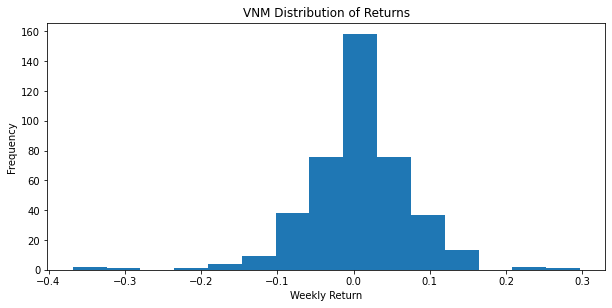

<Figure size 720x2160 with 0 Axes>

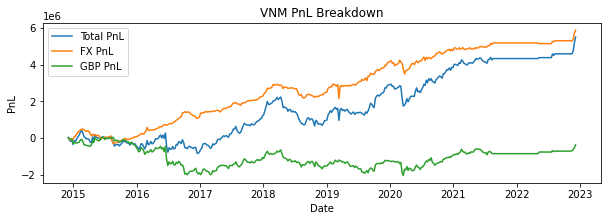

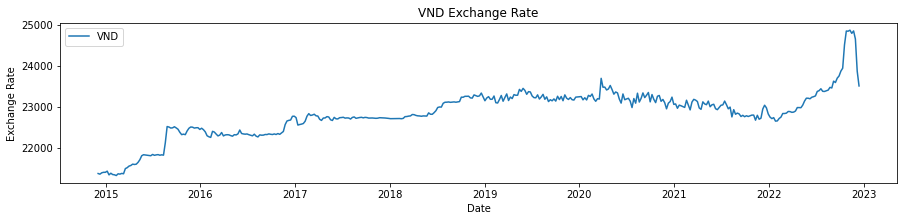

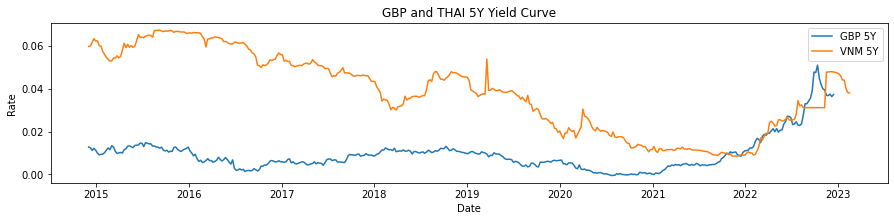

In [854]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title("VNM Distribution of Returns")
plt.hist(VNM_carry['return'], bins=15)
plt.xlabel("Weekly Return")
plt.ylabel("Frequency")

plt.figure(figsize=(10,30))
plt.subplots(figsize = (10,10))
plt.subplot(3,1,1)
plt.plot(VNM_carry['traded_pnl'].cumsum(), label = 'Total PnL')
plt.plot(VNM_carry['traded_fx_pnl'].cumsum(), label = 'FX PnL')
plt.plot(VNM_carry['traded_GBP_pnl'].cumsum(), label = 'GBP PnL')
plt.title("VNM PnL Breakdown")
plt.xlabel("Date")
plt.ylabel("PnL")
plt.legend()

plt.subplots(figsize=(15,10))
plt.subplot(3,1,2)
plt.plot(VNM_data['Exchange Rate'], label = 'VND')
plt.title("VND Exchange Rate")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()

plt.subplots(figsize=(15,10))
plt.subplot(3,1,2)
plt.plot(THAI_data['GBP5Y'], label = 'GBP 5Y')
plt.plot(VNM_YC2[5], label = 'VNM 5Y')
plt.title("GBP and THAI 5Y Yield Curve")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.legend()

In [800]:
VNM_trades = VNM_carry['traded_pnl'].count()

VNM_carry_stats = [
    {'Trade Sharpe': VNM_Sharpe, 'Number of Weeks Traded': VNM_trades, 'Average profit per trade': VNM_carry['traded_pnl'].sum()/VNM_trades}
]
print(tabulate(VNM_carry_stats, headers='keys'))

  Trade Sharpe    Number of Weeks Traded    Average profit per trade
--------------  ------------------------  --------------------------
       0.09845                       418                     13169.7


# VND Carry Trade
# Analysis 
Our distribution of returns is centered around 0, and has a fatter left tail which is sort of confusing considering we made profit on this trade. Our PnL looks good at first, but if we take it in the context of the whole sample it is not that impressive. We are trading 10,000,000 weekly for the whole sample, when the spread is above 50 bps. That traded amount over the sample is huge, and our PnL only being 6 million is very low. While it is positive, the return percentage is not very high, especially because the amount of risk we are exposed to because of our trading frequency and amount traded. Our Sharpe ratio is low as well, which makes this seem not so attractive. Our total PnL is highly correlated to the part of the trade involving VND. It can be seen from the graph that they are very correlated. When the VND is weakening against the dollar, our PnL while positive still struggles. The strengthening in 2022-2023 of the VND against the dollar was very good for the trade. While it was indeed a huge move, we profited greatly at the end of our sample. When looking at the yield curves of GBP and VND we can see also that we are losign money when the spread is huge. Where after 2017 we begin to make a lot of profit because the spread is getting tighter. We can also see that after 2022 there is not much trading going on because the spread is so tight, and in some cases they are inverted. 

# Economic Intuition
Vietnam prior to 2015 was a country trying to gain its footing in the world economy. There was a lot of turmoil leading up to the growth of the Vietnamese dong. The Vietnam war was a hug obstacle, and since 1986 they had reformed their econom. In the time since 1986 Vietnam has seen very good growth, from a very poor nation to a middle income one in such a short amount of time. However, along with other Asian countries over our sample their currencies have struggled against the USD. In 2015 the VND was devalued which can be seen in the graph of the exchange rate. Since 2015 the currency has struggled against the dollar, with more economic uncertainty from 2021-2023. However, we see a strengthening of the VND at the end of our sample. This is very good for our carry trade. A lot of these smaller currencies appear to be very reactive to what the USA is doing with interest rates and how we navigate through these tough economic times.

# Improvement
In the case of the VND our strategy loses a lot of money during the period of devaluation of the VND. In times where governments are devaluing or currencies are struggling, we should either bow out, or flip to the other side of the trade. The VND for most of the sample kept getting weaker and weaker. Our trade did well from 2020-2022 because the VND was strengthening and it was not moving up or down too much. When currencies stabilize I think it is a good opportunity to get into the trade as it becomes more predictable. The difficult thing with foreign currency is what governments do to the currency. At any moment the currency could get devalued, or something could happen where the country enters bad economic times. I think a strategy where we pick and chose our spots better would yield much higher returns. Rather than maintaining the same strategy over such a long period of time, especially with economic uncertainty surrounding some countries. 

In [794]:
THAI_carry = carry_trade(THAI_data, THAI_zero3)
THAI_carry['return'] = THAI_carry['traded_pnl']/2_000_000
THAI_Sharpe = THAI_carry['return'].mean()/THAI_carry['return'].std()

In [795]:
THAI_kurtosis = THAI_carry['return'].kurtosis()
THAI_skew = THAI_carry['return'].skew()
THAI_quartiles = THAI_carry['return'].quantile([.25,.5,.75])
THAI_describe = THAI_carry[['return']].describe().transpose()
THAI_describe['kurtosis'] = THAI_kurtosis
THAI_describe['skew'] = THAI_skew
THAI_describe = THAI_describe.append(THAI_quartiles, ignore_index=True)
THAI_describe

,count,unique,top,freq,kurtosis,skew,0.25,0.5,0.75
0,419.0,333.0,0.0,87.0,2.994224,-0.353167,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,-0.021879,0.0,0.03814


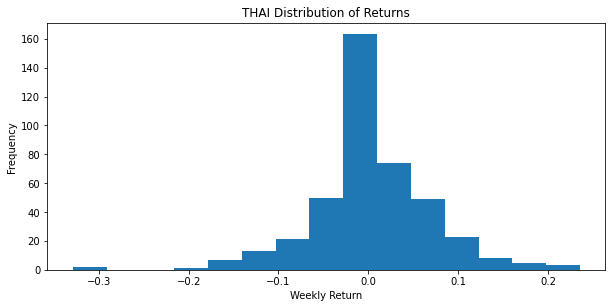

<Figure size 720x2160 with 0 Axes>

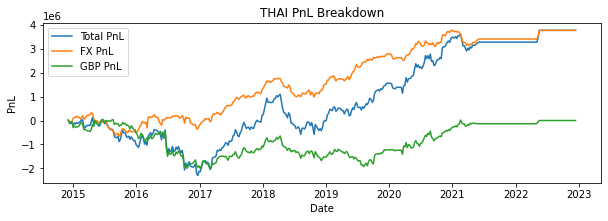

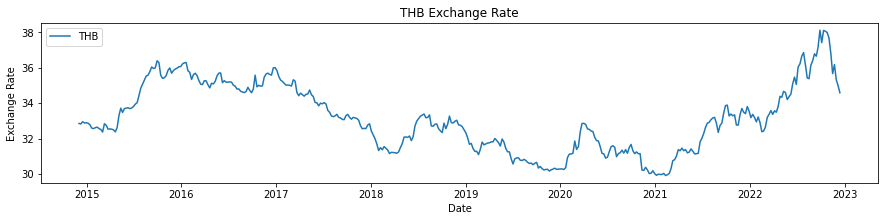

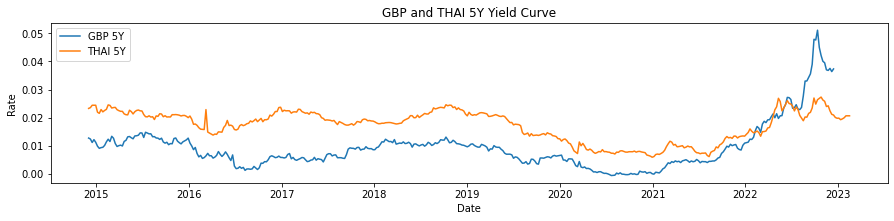

In [855]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title("THAI Distribution of Returns")
plt.hist(THAI_carry['return'], bins=15)
plt.xlabel("Weekly Return")
plt.ylabel("Frequency")

plt.figure(figsize=(10,30))
plt.subplots(figsize = (10,10))
plt.subplot(3,1,1)
plt.plot(THAI_carry['traded_pnl'].cumsum(), label = 'Total PnL')
plt.plot(THAI_carry['traded_fx_pnl'].cumsum(), label = 'FX PnL')
plt.plot(THAI_carry['traded_GBP_pnl'].cumsum(), label = 'GBP PnL')
plt.title("THAI PnL Breakdown")
plt.xlabel("Date")
plt.ylabel("PnL")
plt.legend()

plt.subplots(figsize=(15,10))
plt.subplot(3,1,2)
plt.plot(THAI_data['Exchange Rate'], label = 'THB')
plt.title("THB Exchange Rate")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()

plt.subplots(figsize=(15,10))
plt.subplot(3,1,2)
plt.plot(THAI_data['GBP5Y'], label = 'GBP 5Y')
plt.plot(THAI_YC2[5], label = 'THAI 5Y')
plt.title("GBP and THAI 5Y Yield Curve")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.legend()

In [799]:
THAI_trades = THAI_carry['traded_pnl'].count()

THAI_carry_stats = [
    {'Trade Sharpe': THAI_Sharpe, 'Number of Weeks Traded': THAI_trades, 'Average profit per trade': THAI_carry['traded_pnl'].sum()/THAI_trades}
]
print(tabulate(THAI_carry_stats, headers='keys'))

  Trade Sharpe    Number of Weeks Traded    Average profit per trade
--------------  ------------------------  --------------------------
     0.0680815                       419                     9013.88


# Thai Baht Carry Trade
# Analysis
Our distribution of returns has a fat left tail and is centered around less than 0. This is definitely cause for concern again like I mentioned for the VND trade where it looks like we should be losing money, but our PnL over the sample is slightly positive relative to our total notional. Our sharpe is also very low. Through looking at our PnL graph it is not as obvious what our PnL is correlated to, unlike with our VND trade it was very obvious. Here our PnL is a combination of the 2 PnLs where one does not dominate the other. Again we see very negative PnL in the beginning of our sample because the THB is weakening against the USD. Again here it can be seen that our trade does better as the spread tightens, from 2019-2021 our PnL goes up a lot. However, This is not the main reason our PnL is going up. In the same time period the Thai Baht is strengthing a lot against the USD, the most in the sample. Which as a result gives us much higher PnL. It is also important to note that even though our spread is relatively tight at the beginning of the sample, the Thai Baht weakens a lot and stays weak. This results in us losing a lot of money. Like the VND, we are not trading much after 2021. The spread is getting much tighter and in some cases inverts, like the VND did.

# Economic Intuition
In the 1990s the small Asian currencies saw a huge collapse. There is speculation to who or why this happened but the prevailing theory is that George Soros and his hedge fund amongst other investors caused this with their trades in the Asian markets. The currencies rebounded eventually and tried to stabilize once again. As the countries and their economies became more sophisticated their currencies became more stable. However, they were still sensitive. In 2015 the Bank of Thailand cut benchmark interest rates by 25 basis points. The resulting affect on the currency can be seen in the graph of the Thai Baht exchange rate. The Bank of Thailand had been supportin gthe currency for a logn time and they sort of stopped in 2015. The cut in interest rates caused the weakening of their currency against the USD. Eventually the Baht got stronger and our trade became more profitable. In 2022 the rally of the Baht stopped and stalled because they lost a lot of tourism from China. In a country like Thailand tourism is very important, and when you lose that from the biggest country in the world thats a problem. The Baht's value took another dive, but in our case we were not trading because at the same time the spreads were too tight and sometimes inverted.

# Improvements
Recommendations for the Baht will be similar to that of the VND. In these smaller currencies of countries it can prove unprofitable to be trading in their currencies because any legislation change from another country or political change can make the currency very weak. We need to pay attention to the economic situations of the countries and if we are too late because the currency has already been devalued in some way we need to stop trading. A regime shift can prove unprofitable and we must wait out the storm and wait for the currency to become stable again or strengthen over a longer period of time. Having the same strategy over an 8 year period with these currencies is going to increase our risk to a downturn in the currency which appears to happen somewhat frequently. In those times we need to re assess, stop trading and find another angle.


In [802]:
PAK_carry = carry_trade(PAK_data, PAK_zero3)
PAK_carry['return'] = PAK_carry['traded_pnl']/2_000_000
PAK_Sharpe = PAK_carry['return'].mean()/PAK_carry['return'].std()

In [803]:
PAK_kurtosis = PAK_carry['return'].kurtosis()
PAK_skew = PAK_carry['return'].skew()
PAK_quartiles = PAK_carry['return'].quantile([.25,.5,.75])
PAK_describe = PAK_carry[['return']].describe().transpose()
PAK_describe['kurtosis'] = PAK_kurtosis
PAK_describe['skew'] = PAK_skew
PAK_describe = PAK_describe.append(PAK_quartiles, ignore_index=True)
PAK_describe

,count,unique,top,freq,kurtosis,skew,0.25,0.5,0.75
0,285.0,281.0,0.0,5.0,5.513202,-0.790155,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,-0.034657,0.000255,0.045532


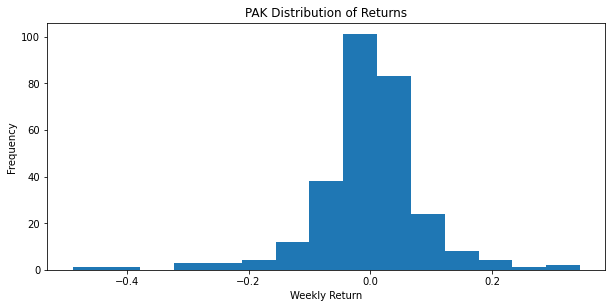

<Figure size 720x2160 with 0 Axes>

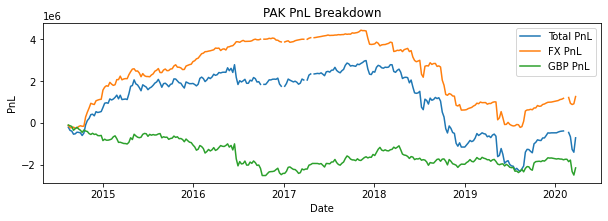

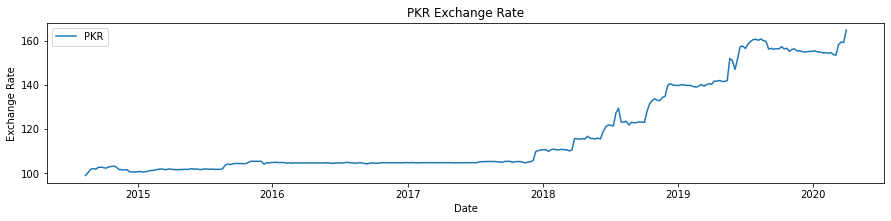

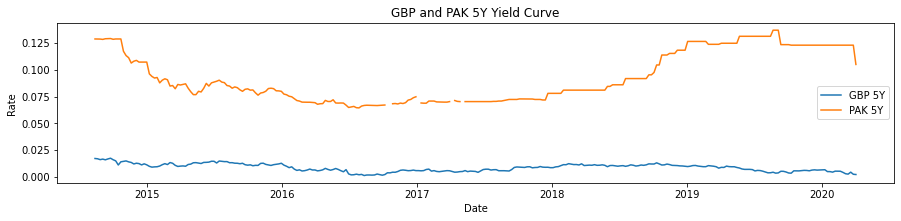

In [856]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title("PAK Distribution of Returns")
plt.hist(PAK_carry['return'], bins=15)
plt.xlabel("Weekly Return")
plt.ylabel("Frequency")

plt.figure(figsize=(10,30))
plt.subplots(figsize = (10,10))
plt.subplot(3,1,1)
plt.plot(PAK_carry['traded_pnl'].cumsum(), label = 'Total PnL')
plt.plot(PAK_carry['traded_fx_pnl'].cumsum(), label = 'FX PnL')
plt.plot(PAK_carry['traded_GBP_pnl'].cumsum(), label = 'GBP PnL')
plt.title("PAK PnL Breakdown")
plt.xlabel("Date")
plt.ylabel("PnL")
plt.legend()

plt.subplots(figsize=(15,10))
plt.subplot(3,1,2)
plt.plot(PAK_data['Exchange Rate'], label = 'PKR')
plt.title("PKR Exchange Rate")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()

plt.subplots(figsize=(15,10))
plt.subplot(3,1,2)
plt.plot(PAK_data['GBP5Y'], label = 'GBP 5Y')
plt.plot(PAK_YC2[5], label = 'PAK 5Y')
plt.title("GBP and PAK 5Y Yield Curve")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.legend()

In [807]:
PAK_trades = PAK_carry['traded_pnl'].count()
PAK_carry_stats = [
    {'Trade Sharpe': PAK_Sharpe, 'Number of Weeks Traded': PAK_trades, 'Average profit per trade': PAK_carry['traded_pnl'].sum()/PAK_trades}
]
print(tabulate(PAK_carry_stats, headers='keys'))

  Trade Sharpe    Number of Weeks Traded    Average profit per trade
--------------  ------------------------  --------------------------
    -0.0135537                       285                    -2456.39


# PKR Carry Trade
# Analysis
Our returns on the PKR carry trade have a fat left rail and are more centered around < 0 then > 0. Before we make any assumptions about what is going on with the returns, we must look at all factors we looked at for our trade. Prior to 2018, our strategy already yielded a lot of profit. If we compare it to our VND trade, which made 6 million overall. Our PKR trade made 4 million in the first 3 years of the trade. It was very profitable over this time period. Looking at the yield curves we see that the spread starts large and narrows until 2018. We also see that our FX rate has remained somewhat constant from 2015-2018. These conditions clearly are ideal for our trade. After looking at that period we can see where everything went so wrong. Our spread begins to open up again after 2018, and the PKR gets much weaker relative to the USD. We lose all of a profit from the previous period in just under a year. While very bad, this is impressive. It is clear what happened when looking at the FX rate and the yield curves why our profits took a dive. We continue on this path after 2019 and it only gets worse. Teh strategy sharpe, returns, and PnL gets much worse and we exit in 2023 at a loss. 

# Economic Intuition
The big take away from our data and graphs is what actually happened in late 2017-2018. The Pakistani Rupee plunged because the central bank was on a roll of devaluing the currency. Through reading an article on CNBC, it appears as though the central bank devalued the currency 6 times in 12 months. This is where our problem for our trade lies. The PKR's value was devalued at an alarming rate, and as a result we lost a lot of money on our trade. In the years leading up to these devaluations, we made a lot of money and the currency was very stable. Unfortunately, we continued to execute our carry trade as the PKRs value took a nose dive. Up until the end of our sample, the PKR continues to plunge and reaches a new low towards the end of the sample. The currency never recovered. While the spread was relatively wide, that is not the cause for concern in our strategy as it did not affect us as much as teh drop in value of the PKR did. 

# Improvements
There seems to be a common theme here amongst these smaller Asian currencies. When the currencies take a dive, so do our profits. In the other currencies the spreads became very tight and sometimes inverted later in our sample. The PAK GBP spread looks somewhat normal, even though it ends up as wide as it was at the beginning of the sample. Our losses can directly be attributed to the mass devaluation of the currency in 2017-2018. In the other currencies we were able to recover some profits because we stayed in the trade through the volatility of the exchange rates. Here, it never recovers. This strategy would benefit most from my previous recommendations. When the devaluation happens, get out. After exiting we would have to monitor the currencies exchange rate to see if it stabilizes and if its safe to start trading again. In this case our profits are very good prior to the devaluation, it would benefit us greatly to just exit with our profits and monitor the situation as this no longer becomes profitable. PKR never recovers over our sample and therefore we should stay out until it becomes stable again.

In [879]:
PHIL_carry = carry_trade(PHIL_data, PHIL_zero3)
PHIL_carry

,pounds,GBP_pnl,bond_price,interest,cash,Pounds,Fx,position,new_bond,new_value,FX_pnl,total_pnl,spread_check,traded_pnl,traded_fx_pnl,traded_GBP_pnl
2014-12-03,6377560.0,19126.412832,0.999978,1426.853753,10000000,NaN,446971700.0,446981643.99366,0.99934,446686850.209608,17365.519235,36491.932067,True,36491.932067,17365.519235,19126.412832
2014-12-10,6363450.0,-71453.817181,0.999981,1424.888553,10000000,NaN,445912500.0,445921136.062534,0.998737,445358100.625776,-50818.413352,-122272.230533,True,-122272.230533,-50818.413352,-71453.817181
2014-12-17,6421420.0,-7957.552584,0.999982,1423.550038,10000000,NaN,447632900.0,447640853.320689,0.998775,447092687.215846,8053.74343,96.190846,True,96.190846,8053.74343,-7957.552584
2014-12-24,6428950.0,14231.783938,0.999981,1427.204652,10000000,NaN,446732900.0,446741609.217245,1.00081,447103477.557185,-13420.073089,811.710849,True,811.710849,-13420.073089,14231.783938
2014-12-31,6418660.0,-247247.168286,0.999981,1427.788793,10000000,NaN,447704300.0,447713028.155035,1.010159,452261177.758912,34120.218744,-213126.949541,True,-213126.949541,34120.218744,-247247.168286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-16,8423850.0,15575.927294,0.999926,5366.818633,10000000,NaN,574684960.0,574727267.820776,1.009228,580031099.414952,134645.337532,150221.264826,True,150221.264826,134645.337532,15575.927294
2022-11-23,8413100.0,67872.537927,0.999966,5484.119865,10000000,NaN,572325010.0,572344441.411795,1.005155,575294785.341476,184733.142109,252605.680036,True,252605.680036,184733.142109,67872.537927
2022-11-30,8347490.0,104333.286233,0.999972,5659.313578,10000000,NaN,564859950.0,564876004.954132,1.008424,569634424.871582,266458.234442,370791.520675,True,370791.520675,266458.234442,104333.286233
2022-12-07,8244530.0,152036.923745,0.999975,5874.559122,10000000,NaN,554849990.0,554864034.974691,1.004699,557471578.235389,5593.874035,157630.79778,True,157630.79778,5593.874035,152036.923745


# *NOTE

# I was able to calculate the data from for the Philippine Peso but for some reason un unbeknown to me I could not perform any operations on it and could not do any analysis. Even though I did the same thing for the previous 3 currencies, this one did not work.

# Instead, I was able to load New Zealand yield curves and the NZD data and perform analysis on it for a carry trade. The results are below.

In [875]:
NZL_carry = carry_trade(NZL_data, NZL_zero3)
NZL_carry['return'] = NZL_carry['traded_pnl']/2_000_000
NZL_Sharpe = NZL_carry['return'].mean()/NZL_carry['return'].std()

In [876]:
NZL_kurtosis = NZL_carry['return'].kurtosis()
NZL_skew = NZL_carry['return'].skew()
NZL_quartiles = NZL_carry['return'].quantile([.25,.5,.75])
NZL_describe = NZL_carry[['return']].describe().transpose()
NZL_describe['kurtosis'] = NZL_kurtosis
NZL_describe['skew'] = NZL_skew
NZL_describe = NZL_describe.append(NZL_quartiles, ignore_index=True)
NZL_describe

,count,unique,top,freq,kurtosis,skew,0.25,0.5,0.75
0,728.0,638.0,0.0,91.0,2.592945,-0.383861,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,-0.054662,0.0,0.066308


In [880]:
NZL_2009 = NZL_YC2[NZL_YC2.index.year >= 2009]

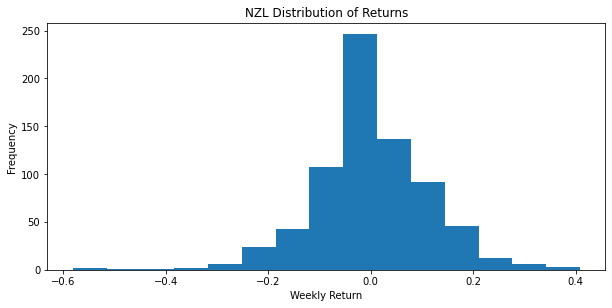

<Figure size 720x2160 with 0 Axes>

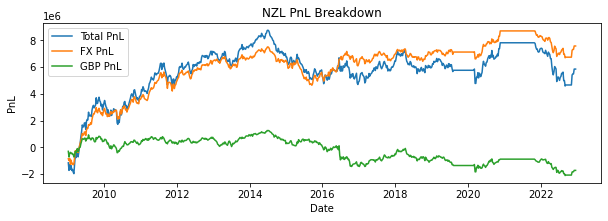

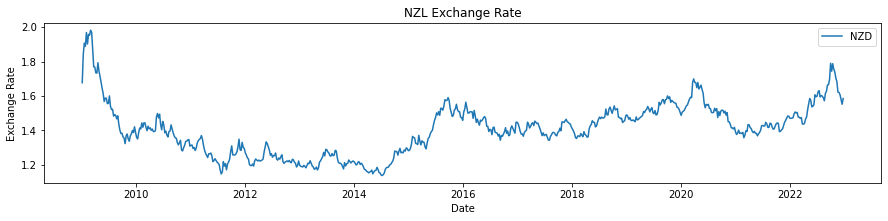

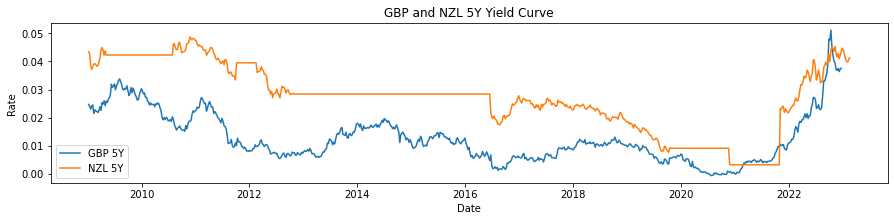

In [882]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title("NZL Distribution of Returns")
plt.hist(NZL_carry['return'], bins=15)
plt.xlabel("Weekly Return")
plt.ylabel("Frequency")

plt.figure(figsize=(10,30))
plt.subplots(figsize = (10,10))
plt.subplot(3,1,1)
plt.plot(NZL_carry['traded_pnl'].cumsum(), label = 'Total PnL')
plt.plot(NZL_carry['traded_fx_pnl'].cumsum(), label = 'FX PnL')
plt.plot(NZL_carry['traded_GBP_pnl'].cumsum(), label = 'GBP PnL')
plt.title("NZL PnL Breakdown")
plt.xlabel("Date")
plt.ylabel("PnL")
plt.legend()

plt.subplots(figsize=(15,10))
plt.subplot(3,1,2)
plt.plot(NZL_data['Exchange Rate'], label = 'NZD')
plt.title("NZL Exchange Rate")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()

plt.subplots(figsize=(15,10))
plt.subplot(3,1,2)
plt.plot(NZL_data['GBP5Y'], label = 'GBP 5Y')
plt.plot(NZL_2009[5], label = 'NZL 5Y')
plt.title("GBP and NZL 5Y Yield Curve")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.legend()

In [878]:
NZL_trades = NZL_carry['traded_pnl'].count()
NZL_carry_stats = [
    {'Trade Sharpe': NZL_Sharpe, 'Number of Weeks Traded': NZL_trades, 'Average profit per trade': NZL_carry['traded_pnl'].sum()/NZL_trades}
]
print(tabulate(NZL_carry_stats, headers='keys'))

  Trade Sharpe    Number of Weeks Traded    Average profit per trade
--------------  ------------------------  --------------------------
     0.0354956                       728                      8030.3


# New Zealand Carry Trade
# Analysis
Our NZL carry trade does very well in its first 4 years. This makes sense as our spread is somewhat tight, and the NZD strengthened a lot against the USD. The currency strengthened a lot in 2009 and remained strong through 2015. In this case our distribution of returns has a fatter right tail. This is a good thing to see after looking at the other Asian currencies with fatter left tails on the returns. We still need to dive into the graphs and data to see what is going on. Looking at the Sharpe and our PnL we can see after that period of profits, our returns tail off. The PnL after 2015 remains around the same level, as we are not losing too much money or gaining much money. The NZD weakens after 2015 and we begin to lose our profits, our PnL remains somewhat constant. Even though we end up with around 6 million in PnL, that does not really compare to the 8 million we had just after 4 years of trading. Again here our total PnL is highly correlated to the PnL we are getting from the NZD. Overall this strategy is initially very profitable and then we just sit there for a while at around the same level. The spread also gets very tight after 2016, which we can see from our other trades that this is good. However, the drop in value of NZD is the large contributor to our drop in profit level. 

# Economic Intuition
This fall in the NZD against the USD can in small part be attributed to devaluation by the central bank in 2015. However, interestingly enough, the drop in value is caused by the massive drop in dairy prices. The main export of New Zealand being dairy, it drove the NZDs price down. Similar to the other Asian currencies, any change to the country economically can mean drastic exchange rate changes. We saw with the Thai Baht that the stop of tourism from China to Thailand was the main contributor to the drop in value of the Thai Baht. Here we see the main export of New Zealand drop drastically in price, causing the NZD to fall as well. New Zealand during the same time also saw a wider interest rate gap. The NZD never returned to its previous level and has yet to stabilize as we see in our graph. 

# Improvements
I would recommend the same thing here as I did for the other currencies. When an economic event or something happens that causes the currencies value to drop, we get out and stop trading. Similar to what we saw in the PKR carry trade, we saw huge profits only 4 years after starting to trade. Here, we reach a peak of 8 million PnL 5 years after starting the carry trade. When the prices of the main export of a country drop, we should react and stop trading. We then wait to see what happens. In the case of the NZD, it never really returns to the level it was and becomes much less profitable. But, if we get out and stop trading at around 2015 we leave with our 8 million in profit unscathed and ready to look elsewhere. 



# Conclusion
These carry trades prove to be profitable. Even though the profits may not seem like a lot, in all but a couple currencies we were able to make a lot of money. While the total money we traded was a lot, if we just look at how much we are exposed to each trade our profits are good. We only have 10 million out on each trade at a time, so 6 million or 8 million over the course of our sample is still good. All of the trades are very sensitive to the weakening of the foreign currencies. Especially when it happens all of a sudden because they become unstable for a period of time which causes our trade to become less profitable. The spreads we are dealing with also matter, however the exchange rate of the foreign currency is the main driver of profit for this strategy